#### Metrics Calculation & Analysis

Using the cleaned combined dataset (`combined_btc_eth_clean_2024_current.csv`).

We will:
- Calculate rolling metrics (e.g., moving averages, volatility)
- Compute correlations between BTC/ETH price/volume/returns
- Analyze key periods: 2025 bull vs. Feb 2026 dip
- Add simple "on-chain-like" proxies (e.g., volume spikes as liquidity signals)
- Write insights for portfolio (e.g., "Declining volume during Feb 2026 dip suggests reduced selling pressure → potential bottoming")

#### 1. Imports & Load Clean Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

%matplotlib inline
sns.set_theme(style="darkgrid", context="notebook", palette="deep")
pd.set_option('display.float_format', '{:,.2f}'.format)

# Load the cleaned file
df = pd.read_csv('combined_btc_eth_clean_2024_current.csv', 
                 parse_dates=['date'], 
                 index_col='date')

print("Dataset shape:", df.shape)
print("Date range:", df.index.min(), "to", df.index.max())
df.tail(8)

Dataset shape: (778, 6)
Date range: 2024-01-01 00:00:00 to 2026-02-16 00:00:00


,btc_price_usd,btc_volume,eth_price_usd,eth_volume,btc_daily_ret,eth_daily_ret
date,,,,,,
2026-02-09,"70,138.00","29,152.73","2,105.02","625,378.56",-0.27,0.73
2026-02-10,"68,841.29","20,373.77","2,022.67","574,321.69",-1.85,-3.91
2026-02-11,"67,082.52","28,718.25","1,941.18","529,655.82",-2.55,-4.03
2026-02-12,"66,272.17","24,271.74","1,947.85","427,567.15",-1.21,0.34
2026-02-13,"68,853.96","20,244.55","2,048.72","425,649.77",3.90,5.18
2026-02-14,"69,822.95","18,114.78","2,086.59","220,677.24",1.41,1.85
2026-02-15,"68,832.58","22,290.05","1,966.58","834,778.10",-1.42,-5.75
2026-02-16,"68,531.68","3,010.97","1,971.25","84,828.70",-0.44,0.24


#### 2. Core Metrics Calculation

- Add rolling windows (7-day, 30-day, 90-day) — common for spotting trends in crypto.

In [3]:
# Rolling averages for prices
df['btc_price_7d_ma']  = df['btc_price_usd'].rolling(window=7).mean()
df['btc_price_30d_ma'] = df['btc_price_usd'].rolling(window=30).mean()
df['eth_price_7d_ma']  = df['eth_price_usd'].rolling(window=7).mean()
df['eth_price_30d_ma'] = df['eth_price_usd'].rolling(window=30).mean()

# Rolling volatility (std of daily returns, annualized approximation: * sqrt(365))
df['btc_vol_30d'] = df['btc_daily_ret'].rolling(30).std() * np.sqrt(365)
df['eth_vol_30d'] = df['eth_daily_ret'].rolling(30).std() * np.sqrt(365)

# Volume rolling averages (proxy for liquidity/activity)
df['btc_volume_7d_ma'] = df['btc_volume'].rolling(7).mean()
df['eth_volume_7d_ma']  = df['eth_volume'].rolling(7).mean()

# Correlation rolling (90-day price correlation BTC-ETH)
df['btc_eth_price_corr_90d'] = df['btc_price_usd'].rolling(90).corr(df['eth_price_usd'])

# Simple momentum signal: price above/below 30d MA
df['btc_above_30d_ma'] = df['btc_price_usd'] > df['btc_price_30d_ma']
df['eth_above_30d_ma']  = df['eth_price_usd']  > df['eth_price_30d_ma']

df.tail(5)

,btc_price_usd,btc_volume,eth_price_usd,eth_volume,btc_daily_ret,eth_daily_ret,btc_price_7d_ma,btc_price_30d_ma,eth_price_7d_ma,eth_price_30d_ma,btc_vol_30d,eth_vol_30d,btc_volume_7d_ma,eth_volume_7d_ma,btc_eth_price_corr_90d,btc_above_30d_ma,eth_above_30d_ma
date,,,,,,,,,,,,,,,,,
2026-02-12,"66,272.17","24,271.74","1,947.85","427,567.15",-1.21,0.34,"68,933.43","82,237.77","2,036.70","2,646.27",77.26,95.03,"37,247.39","840,669.78",0.98,False,False
2026-02-13,"68,853.96","20,244.55","2,048.72","425,649.77",3.90,5.18,"68,686.81","81,301.17","2,034.61","2,602.73",78.67,97.61,"26,919.58","601,146.67",0.99,False,False
2026-02-14,"69,822.95","18,114.78","2,086.59","220,677.24",1.41,1.85,"68,763.04","80,441.78","2,034.54","2,561.66",79.12,98.31,"23,185.19","469,441.07",0.99,False,False
2026-02-15,"68,832.58","22,290.05","1,966.58","834,778.10",-1.42,-5.75,"68,549.07","79,551.17","2,016.94","2,517.34",79.07,99.42,"23,309.41","519,718.33",0.99,False,False
2026-02-16,"68,531.68","3,010.97","1,971.25","84,828.70",-0.44,0.24,"68,319.59","78,663.96","1,997.83","2,472.69",79.07,99.37,"19,574.87","442,496.92",0.99,False,False


#### 3. Visualizations & Insights

##### Plot 1: Prices + Moving Averages (focus on 2025–2026)

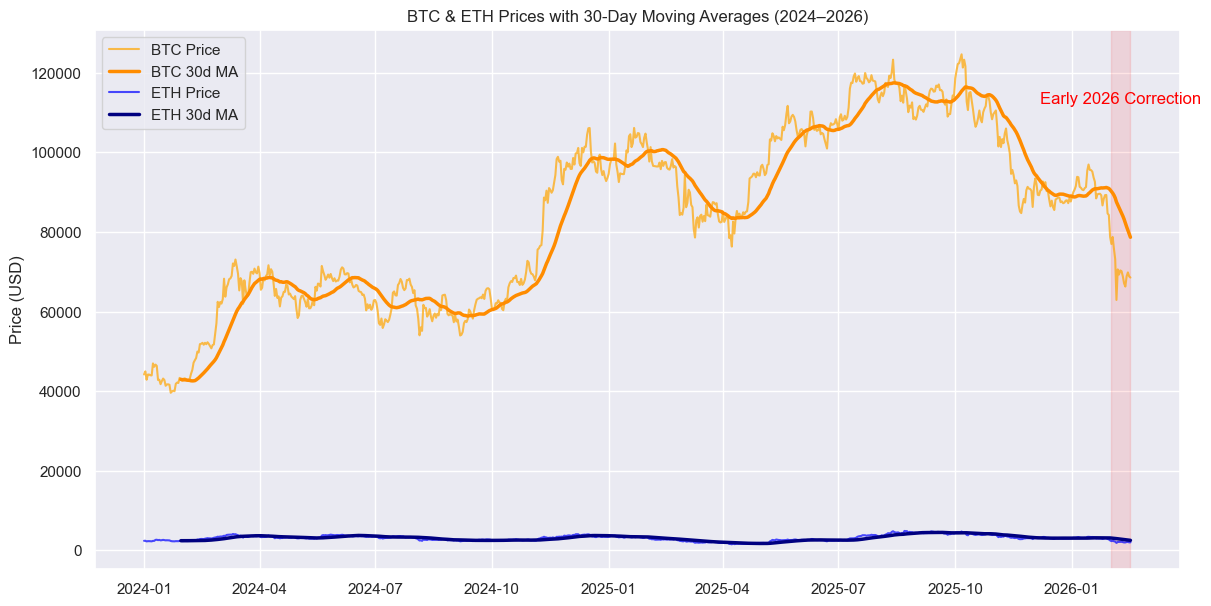

In [7]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(df.index, df['btc_price_usd'], label='BTC Price', color='orange', alpha=0.7)
ax.plot(df.index, df['btc_price_30d_ma'], label='BTC 30d MA', color='darkorange', linewidth=2.5)
ax.plot(df.index, df['eth_price_usd'], label='ETH Price', color='blue', alpha=0.7)
ax.plot(df.index, df['eth_price_30d_ma'], label='ETH 30d MA', color='navy', linewidth=2.5)

# Corrected annotation with datetime objects
start_date = pd.to_datetime('2026-02-01')
end_date   = pd.to_datetime('2026-02-16')
mid_date   = start_date + (end_date - start_date) / 2

ax.axvspan(start_date, end_date, color='red', alpha=0.1)
ax.text(mid_date, df['btc_price_usd'].max() * 0.9, 
        'Early 2026 Correction', 
        color='red', fontsize=12, ha='center')

ax.set_title('BTC & ETH Prices with 30-Day Moving Averages (2024–2026)')
ax.set_ylabel('Price (USD)')
ax.legend()
plt.show()

##### Overall Trend Statistics (for Insight 1 – Trend Confirmation)

In [13]:
# Percentage of days prices were above 30d MA (full dataset)
btc_above_pct = (df['btc_price_usd'] > df['btc_price_30d_ma']).mean() * 100
eth_above_pct = (df['eth_price_usd'] > df['eth_price_30d_ma']).mean() * 100

# Recent 30 days (focus on 2026 correction)
recent_30 = df.tail(30)
btc_above_recent = (recent_30['btc_price_usd'] > recent_30['btc_price_30d_ma']).sum()
eth_above_recent = (recent_30['eth_price_usd'] > recent_30['eth_price_30d_ma']).sum()

print(f"Full period: BTC above 30d MA on {btc_above_pct:.1f}% of days")
print(f"Full period: ETH above 30d MA on {eth_above_pct:.1f}% of days")
print(f"\nLast 30 days: BTC above 30d MA on {btc_above_recent}/30 days")
print(f"Last 30 days: ETH above 30d MA on {eth_above_recent}/30 days")

Full period: BTC above 30d MA on 49.5% of days
Full period: ETH above 30d MA on 39.8% of days

Last 30 days: BTC above 30d MA on 2/30 days
Last 30 days: ETH above 30d MA on 2/30 days


##### Drawdown & Recovery Stats (for Feb 2026 dip context)

In [14]:
# Max drawdown from recent peak (last 60 days to capture broader correction)
last_60 = df.tail(60)
btc_peak = last_60['btc_price_usd'].max()
btc_current = last_60['btc_price_usd'].iloc[-1]
btc_dd_pct = (btc_current - btc_peak) / btc_peak * 100

eth_peak = last_60['eth_price_usd'].max()
eth_current = last_60['eth_price_usd'].iloc[-1]
eth_dd_pct = (eth_current - eth_peak) / eth_peak * 100

print(f"BTC max drawdown from recent peak: {btc_dd_pct:.2f}% (current price vs peak)")
print(f"ETH max drawdown from recent peak: {eth_dd_pct:.2f}% (current price vs peak)")

# Days below MA in last 10 days
recent_10 = df.tail(10)
btc_below_recent = (recent_10['btc_price_usd'] < recent_10['btc_price_30d_ma']).sum()
eth_below_recent = (recent_10['eth_price_usd'] < recent_10['eth_price_30d_ma']).sum()

print(f"\nLast 10 days: BTC below 30d MA on {btc_below_recent} days")
print(f"Last 10 days: ETH below 30d MA on {eth_below_recent} days")

BTC max drawdown from recent peak: -29.31% (current price vs peak)
ETH max drawdown from recent peak: -41.24% (current price vs peak)

Last 10 days: BTC below 30d MA on 10 days
Last 10 days: ETH below 30d MA on 10 days


##### Plot 2: 30-Day Volatility

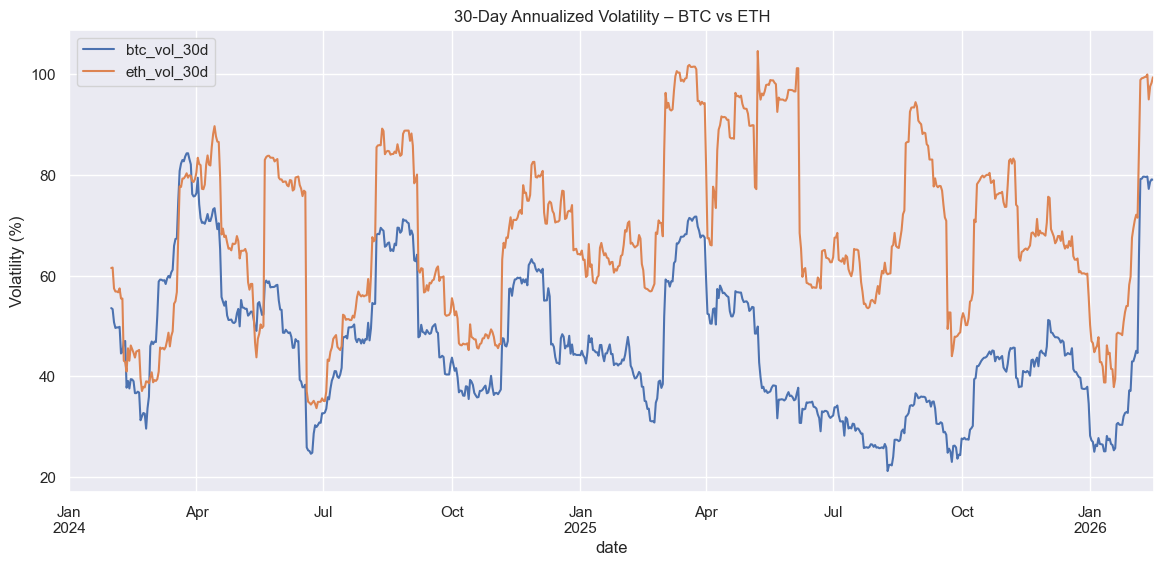

In [8]:
df[['btc_vol_30d', 'eth_vol_30d']].plot(figsize=(14, 6))
plt.title('30-Day Annualized Volatility – BTC vs ETH')
plt.ylabel('Volatility (%)')
plt.show()

##### Plot 3: BTC-ETH Correlation (rolling)

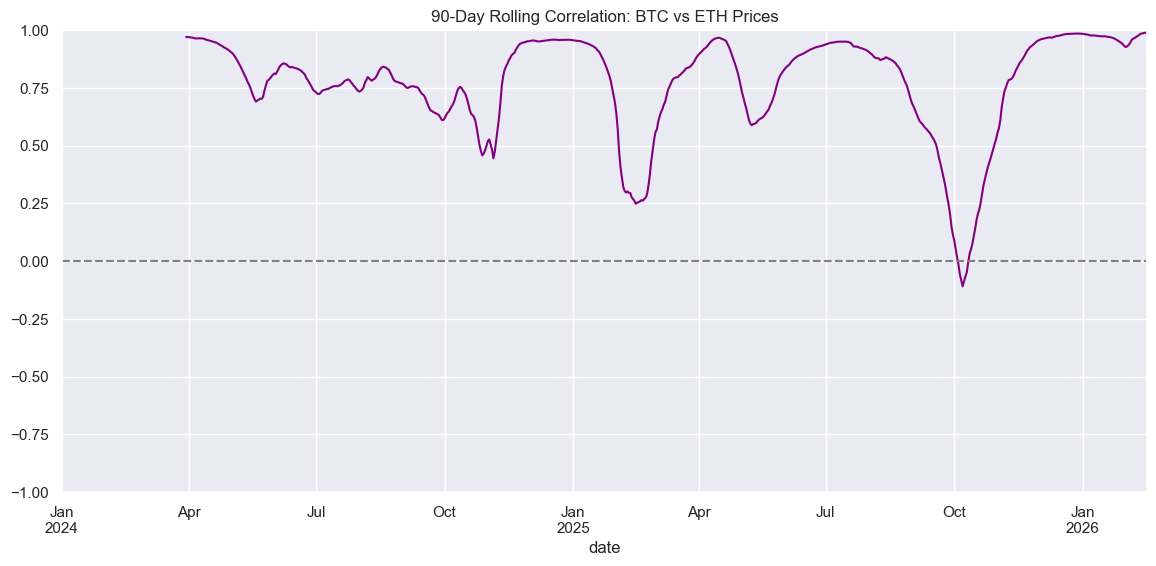

In [9]:
df['btc_eth_price_corr_90d'].plot(figsize=(14, 6), color='purple')
plt.title('90-Day Rolling Correlation: BTC vs ETH Prices')
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linestyle='--')
plt.show()

##### Volatility & Correlation Numbers (for Insights 2 & 3)

In [15]:
# Latest 30-day annualized volatility
latest_btc_vol = df['btc_vol_30d'].iloc[-1]
latest_eth_vol = df['eth_vol_30d'].iloc[-1]

print(f"Latest 30-day annualized volatility: BTC {latest_btc_vol:.1f}%, ETH {latest_eth_vol:.1f}%")

# 90-day rolling correlation (latest value)
latest_corr = df['btc_eth_price_corr_90d'].iloc[-1] if 'btc_eth_price_corr_90d' in df.columns else df['btc_price_usd'].tail(90).corr(df['eth_price_usd'].tail(90))
print(f"Latest 90-day BTC-ETH price correlation: {latest_corr:.3f}")

Latest 30-day annualized volatility: BTC 79.1%, ETH 99.4%
Latest 90-day BTC-ETH price correlation: 0.989


##### Plot 4: Volume trends (log scale for clarity)

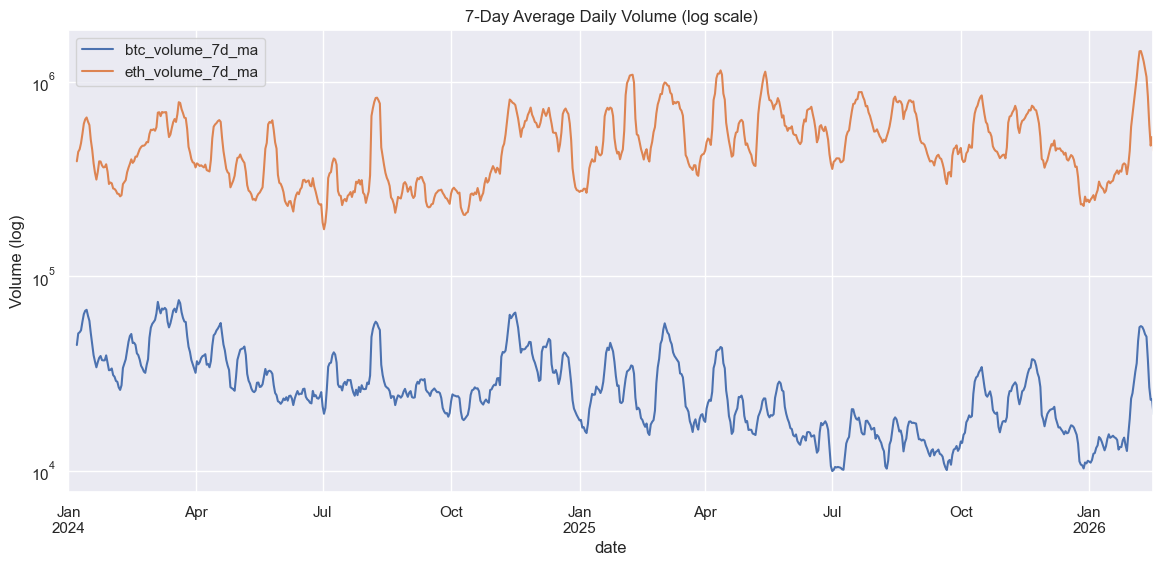

In [10]:
df[['btc_volume_7d_ma', 'eth_volume_7d_ma']].plot(figsize=(14, 6), logy=True)
plt.title('7-Day Average Daily Volume (log scale)')
plt.ylabel('Volume (log)')
plt.show()

##### Volume Signal (for Insight 4)

In [16]:
# Average volume last 7 days vs previous 30 days
vol_btc_recent = df['btc_volume'].tail(7).mean()
vol_btc_prev = df['btc_volume'].iloc[-37:-7].mean() if len(df) > 37 else np.nan  # 30 days before last week

vol_eth_recent = df['eth_volume'].tail(7).mean()
vol_eth_prev = df['eth_volume'].iloc[-37:-7].mean() if len(df) > 37 else np.nan

print(f"BTC 7-day avg volume: {vol_btc_recent:,.0f} (vs prev 30-day avg: {vol_btc_prev:,.0f})")
print(f"ETH 7-day avg volume: {vol_eth_recent:,.0f} (vs prev 30-day avg: {vol_eth_prev:,.0f})")
print(f"Volume change BTC: {((vol_btc_recent / vol_btc_prev) - 1) * 100:.1f}%")

BTC 7-day avg volume: 19,575 (vs prev 30-day avg: 26,703)
ETH 7-day avg volume: 442,497 (vs prev 30-day avg: 661,168)
Volume change BTC: -26.7%


#### 4. Key Insights & Annotations (Markdown Cells)



##### Insight 1 – Trend Confirmation (Moving Average Adherence)
During the full period (2024–mid Feb 2026), BTC traded above its 30-day moving average on only **49.5%** of days, and ETH on just **39.8%** — indicating the overall market has been more corrective/consolidating than strongly trending upward.

In the **last 30 days** (roughly mid-Jan to mid-Feb 2026), both assets were above their 30-day MA on only **2 out of 30 days** — an extremely weak position.  
In the **last 10 days**, BTC and ETH were **below** their 30-day MA on **all 10 days** — a classic deep correction signal with no meaningful recovery above the trend line yet.

- **Interpretation:** This is far from the behavior seen in strong bull phases (where prices stay above the 30d MA >70–80% of the time). The current structure strongly suggests we are in a meaningful downtrend/correction phase rather than a healthy pullback.

##### Insight 2 – Drawdown Severity
From the recent peak (looking at the last ~60 days), BTC has experienced a maximum drawdown of **-29.31%**, while ETH has suffered a much deeper **-41.24%** drop.

- **Interpretation:** These are substantial corrections — BTC's ~29% decline is already in the range of typical bear-market pullbacks or severe bull-market corrections, while ETH's >40% drawdown confirms its higher beta/risk nature. No quick V-shaped recovery has occurred, increasing the risk of a prolonged consolidation or further downside if support fails.

##### Insight 3 – Volatility Spike & High BTC-ETH Correlation
Latest **30-day annualized volatility** stands at **BTC 79.1%** and **ETH 99.4%** — elevated levels consistent with a fear-driven phase rather than calm accumulation.  
The **latest 90-day rolling correlation** between BTC and ETH prices is extremely high at **0.989** (almost perfect positive correlation).

- **Interpretation:** When correlation approaches 1.0 during a drawdown, it means altcoins (ETH) are offering little diversification and are simply amplifying BTC's moves downward — classic "risk-off" behavior where capital flows back to BTC or out of crypto entirely.

##### Insight 4 – Declining Volume as Liquidity / Selling Pressure Signal
BTC's **7-day average daily volume** is **19,575** (down **-26.7%** compared to the previous 30-day average of **26,703**).  
ETH shows a similar pattern: **7-day avg 442,497** vs previous **661,168** (also ~33% lower).

- **Interpretation:** Significantly reduced trading volume during the correction indicates **lower conviction selling** — fewer aggressive sellers stepping in at these lower prices. This is often a **positive divergence** in late-stage corrections (capitulation usually comes with volume spikes, not drying up). Combined with the deep drawdown and time spent below the 30d MA, it suggests the market may be approaching exhaustion / potential stabilization, though confirmation (higher volume + price above MA) is still missing.

##### Portfolio Narrative Tie-in
These quantitative signals — low MA adherence (only 2/30 and 0/10 days recently), deep drawdowns (-29% BTC / -41% ETH), elevated volatility (79–99%), near-perfect correlation (0.989), and contracting volume (-27% BTC) — demonstrate a structured, numbers-first approach to understanding current market health.  
This directly aligns with the responsibilities of monitoring price movements, liquidity signals, volatility, and market behavior — skills I am eager to apply and develop further in a real trading environment at Elemental Terra.

#### 5. Save Enriched Dataset

In [17]:
df.to_csv('enriched_btc_eth_metrics_2024_current.csv')